In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution,
                       fiber_segments_phantom, evaluate_directions,
                       evaluate_metric, pca_noise_classifier)

In [73]:
def pca_denoising(dwi, ps=2, overcomplete=False):
    """ Denoises DWI volumes using PCA analysis and Marchenko–Pastur
    probability theory

    Parameters
    ----------
    dwi : array ([X, Y, Z, g])
        Matrix containing the 4D DWI data.
    ps : int
        Number of neighbour voxels for the PCA analysis.
        Default: 2
    overcomplete : boolean
        If set to True, overcomplete local PCA is computed
        Default: False

    Returns
    -------
    den : array ([X, Y, Z, g])
        Matrix containing the denoised 4D DWI data.
    std : array ([X, Y, Z])
        Matrix containing the noise std estimated using
        Marchenko-Pastur probability theory.
    ncomps : array ([X, Y, Z])
        Number of eigenvalues preserved for the denoised
        4D data.
    """
    # Compute dimension of neighbour sliding window
    m = (2*ps + 1) ** 3

    n = dwi.shape[3]
    den = np.zeros(dwi.shape)
    ncomps = np.zeros(dwi.shape[:3])
    sig2 = np.zeros(dwi.shape[:3])
    if overcomplete:
        wei = np.zeros(dwi.shape)

    for k in range(ps, dwi.shape[2] - ps):
        for j in range(ps, dwi.shape[1] - ps):
            for i in range(ps, dwi.shape[0] - ps):
                # Compute eigenvalues for sliding window
                X = dwi[i - ps: i + ps + 1, j - ps: j + ps + 1,
                        k - ps: k + ps + 1, :]
                X = X.reshape(m, n)
                M = np.mean(X, axis=0)
                X = X - M
                [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

                # Find number of noise related eigenvalues
                c, sig = pca_noise_classifier(L, m)
                ncomps[i, j, k] = n - c
                sig2[i, j, k] = sig

                # Reconstruct signal without noise components
                Y = X.dot(W[:, c:])
                X = Y.dot(W[:, c:].T)
                X = X + M
                X = X.reshape(2*ps + 1, 2*ps + 1, 2*ps + 1, n)

                # Overcomplete weighting
                if overcomplete:
                    w = 1.0 / (1.0 + n - c)
                    wei[i - ps: i + ps + 1,
                        j - ps: j + ps + 1,
                        k - ps: k + ps + 1] = wei[i - ps: i + ps + 1,
                                                  j - ps: j + ps + 1,
                                                  k - ps: k + ps + 1] + w
                    X = X * w
                    den[i - ps: i + ps + 1,
                        j - ps: j + ps + 1,
                        k - ps: k + ps + 1, :] = den[i - ps: i + ps + 1,
                                                     j - ps: j + ps + 1,
                                                     k - ps: k + ps + 1, :] + X
                else:
                    den[i, j, k, :] = X[ps, ps, ps]

    if overcomplete:
        den = den / wei
    return den, np.sqrt(sig2), ncomps

In [3]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

acquisition = 0

if acquisition == 0:

    # Sample 8 diffusion-weighted directions for first shell
    n_pts = 8
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    directions8 = hsph_updated.vertices  # directions for each shell

    # Sample 30 diffusion-weighted directions for second shell
    n_pts = 30
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions30 = hsph_updated.vertices  # directions for each shell

    # Sample 60 diffusion-weighted directions for second shell
    n_pts = 60
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions60 = hsph_updated.vertices  # directions for each shell

    # Create full dataset parameters
    bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                       1000 * np.ones(30), 2000 * np.ones(60)))
    bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
    gtab = gradient_table(bvals, bvecs)
    
else:
    # Sample 30 diffusion-weighted directions for second shell
    n_pts = 30
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions30 = hsph_updated.vertices  # directions for each shell

    # Create full dataset parameters
    bvals = np.hstack((np.zeros(6), 1000 * np.ones(30), 2000 * np.ones(30)))
    bvecs = np.vstack((np.zeros((6, 3)), directions30, directions30))
    gtab = gradient_table(bvals, bvecs)

In [4]:
dtiM = dti.TensorModel(gtab)
dkiM = dki.DiffusionKurtosisModel(gtab)

In [107]:
p = 2
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])

snr = 10
sigma = 50.0 /snr

Phantom = fiber_segments_phantom(gtab, fsigmas[p])

matsiz = Phantom.shape
nrep=20
matsiz = matsiz + (nrep,)
Phantom_all = np.zeros(matsiz)
Pden_all = np.zeros(matsiz)
Pden_over = np.zeros(matsiz)

n1 = np.random.normal(0, sigma, size=Phantom.shape)
n2 = np.random.normal(0, sigma, size=Phantom.shape)
Phantom_gt = _add_rician(Phantom.copy(), n1, n2)
Phantom_all[..., 0] = Phantom_gt

[Pden1, sig, ncomps] = pca_denoising(Phantom_gt.copy(), ps=2)
Pden_all[..., 0] = Pden1
[Pden2, sig, ncomps] = pca_denoising(Phantom_gt.copy(), ps=2, overcomplete=True)
Pden_over[..., 0] = Pden2

for rep in range(1, nrep):
    # add noise
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Noise = _add_rician(Phantom.copy(), n1, n2)
    Phantom_all[..., rep] = Noise
    Phantom_gt = Phantom_gt + Noise
    [Pden1, sig, ncomps] = pca_denoising(Noise.copy(), ps=2)
    Pden_all[..., rep] = Pden1
    [Pden2, sig, ncomps] = pca_denoising(Noise.copy(), ps=2, overcomplete=True)
    Pden_over[..., rep] = Pden2
Phantom_gt = Phantom_gt / nrep

In [108]:
Pen_std = np.mean(np.mean(np.mean(np.std(Pden_all[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
print Pen_std.shape

(104L,)


In [119]:
Over_std = np.mean(np.mean(np.mean(np.std(Pden_over[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
print Over_std.shape

(104L,)


In [120]:
Raw_std = np.mean(np.mean(np.mean(np.std(Phantom_all[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
print Raw_std.shape

(104L,)


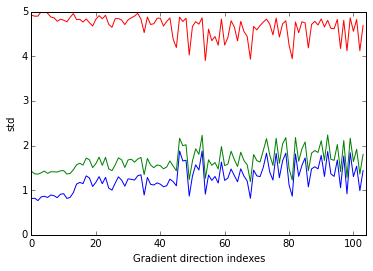

In [121]:
plt.plot(range(Raw_std.size), Raw_std, 'r')
plt.plot(range(Raw_std.size), Pen_std, 'g')
plt.plot(range(Raw_std.size), Over_std, 'b')
plt.axis([0, Raw_std.size, 0, 5])
plt.xlabel('Gradient direction indexes')
plt.ylabel('std')
plt.show()

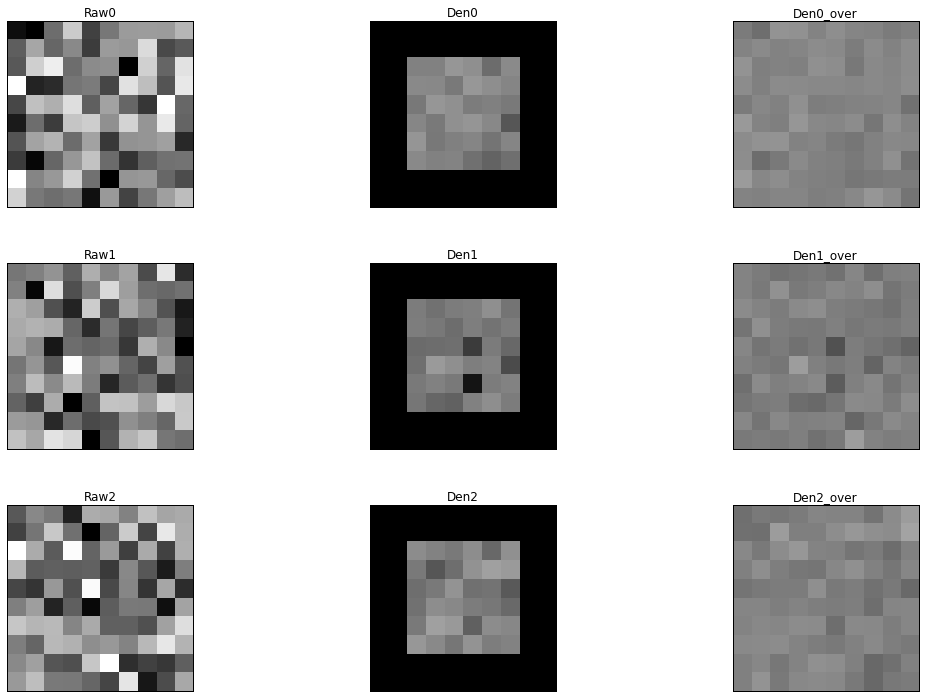

In [122]:
fig2, ax = plt.subplots(3, 3, figsize=(18, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.3)

vol = 0

ax.flat[0].imshow(Phantom_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[0].set_title('Raw0')
ax.flat[1].imshow(Pden_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[1].set_title('Den0')
ax.flat[2].imshow(Pden_over[:, :, 3, vol, 0], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[2].set_title('Den0_over')
ax.flat[3].imshow(Phantom_all[:, :, 3, vol, 1], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[3].set_title('Raw1')
ax.flat[4].imshow(Pden_all[:, :, 3, vol, 1], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[4].set_title('Den1')
ax.flat[5].imshow(Pden_over[:, :, 3, vol, 1], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[5].set_title('Den1_over')
ax.flat[6].imshow(Phantom_all[:, :, 3, vol, 2], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[6].set_title('Raw2')
ax.flat[7].imshow(Pden_all[:, :, 3, vol, 2], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[7].set_title('Den2')
ax.flat[8].imshow(Pden_over[:, :, 3, vol, 2], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[8].set_title('Den2_over')
plt.show()

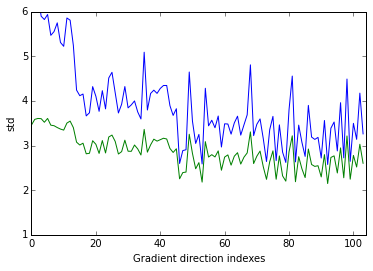

In [123]:
Ganho = Raw_std/Pen_std
Ganho2 = Raw_std/Over_std
plt.plot(range(Raw_std.size), Ganho, 'g')
plt.plot(range(Raw_std.size), Ganho2, 'b')
plt.axis([0, Raw_std.size, 1, 6])
plt.xlabel('Gradient direction indexes')
plt.ylabel('std')
plt.show()